In [1]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt

def calculate_metrics(true_values, pred_values):
    mse = round(mean_squared_error(true_values, pred_values),3)
    mae = round(mean_absolute_error(true_values, pred_values),3)
    r_score = round(r2_score(true_values, pred_values),3)

    return {"mse": mse,
            "mae": mae,
            "r_score": r_score,}

In [2]:
import h2o
from h2o.automl import H2OAutoML

# Start the H2O cluster (locally)
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 21.0.1+12-LTS-29, mixed mode, sharing)
  Starting server from C:\work\DrugDiscovery\drug-discovery-venv\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\38066\AppData\Local\Temp\tmprd_l06mp
  JVM stdout: C:\Users\38066\AppData\Local\Temp\tmprd_l06mp\h2o_38066_started_from_python.out
  JVM stderr: C:\Users\38066\AppData\Local\Temp\tmprd_l06mp\h2o_38066_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Kiev
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.3
H2O_cluster_version_age:,1 month and 7 days
H2O_cluster_name:,H2O_from_python_38066_0ktevi
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.952 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


In [66]:
import os
import sys
sys.path.insert(0, os.path.dirname('C:\work\DrugDiscovery\main_git\XAI_Chem\ml_part'))

import pandas as pd

from ml_part.random_forest.data_prep.preparation import DataPreparation
from ml_part.random_forest.train import RFTrain

CSV_PATH = r'C:\work\DrugDiscovery\main_git\XAI_Chem\data\updated_features\remained_features_25.01.csv'
smiles_filepath = r'C:\work\DrugDiscovery\main_git\XAI_Chem\data\updated_features\smiles_to_index.pkl'

dataPreparation = DataPreparation(CSV_PATH)

X, y = dataPreparation.prepare_data_for_RF(is_pKa=False,
                                           use_mandatory_features=True,
                                           is_remove_outliers=True,
                                           is_remove_nan=True,
                                           outliers_features_to_skip=['dipole_moment'])

features_to_drop = []
for feature_name in X.columns:
    if "angle" in feature_name.lower():
        features_to_drop.append(feature_name)

X = X.drop(features_to_drop, axis=1)

rf_train = RFTrain(X=X, 
                   y=y,
                   smiles_filepath=smiles_filepath,
                   is_pKa=False,
                   k_folds=2)

y_train = rf_train.y_train
X_train = rf_train.X_train

y_test = rf_train.y_test
X_test = rf_train.X_test

train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

print(len(train_df), len(test_df))

train = h2o.H2OFrame(train_df)
test = h2o.H2OFrame(test_df)

True
['dipole_moment', 'FPSA3', 'nHRing', 'avg_atoms_in_cycle', 'angle_X1X2R2', 'PNSA5', 'nN', 'angle_R2X2R1', 'nF', 'nFRing', 'tpsa+f', 'f_freedom', 'f_atom_fraction', 'mol_num_cycles', 'nO', 'nFAHRing', 'angle_R1X1R2', 'distance_between_atoms_in_f_group_centers', 'nC', 'PBF', 'nAHRing', 'mol_volume', 'nFaRing', 'f_to_fg', 'GeomShapeIndex', 'cis/trans', 'PPSA5', 'nFHRing', 'angle_X2X1R1', 'nFaHRing', 'RPCS', 'naRing', 'nFARing', 'dihedral_angle', 'naHRing', 'chirality', 'nARing', 'TASA', 'pKa', 'logP']
FPSA3 [40]
PNSA5 [37, 38]
f_atom_fraction [124]
distance_between_atoms_in_f_group_centers [35]
PBF [40, 71, 127]
mol_volume [127]
logP [82, 83]
Remains rows:105, amount of features: 40
89 16
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [60]:


x = train.columns
# x.remove('C1')
y = "logP"
x.remove(y)

# train[y] = train[y].asfactor()
# test[y] = test[y].asfactor()

aml = H2OAutoML(seed=1, max_runtime_secs_per_model=300)
aml.train(x=x, y=y, training_frame=train, leaderboard_frame=test, fold_column="fold_id")

# View the AutoML Leaderboard
lb = aml.leaderboard
print(lb.head(rows=lb.nrows))

AutoML progress: |


17:50:07.459: Fold column fold_id will be used for cross-validation. nfolds parameter will be ignored.
17:50:07.466: AutoML: XGBoost is not available; skipping it.
17:50:07.585: _min_rows param, The dataset size is too small to split for min_rows=100.0: must have at least 200.0 (weighted) rows, but have only 147.0.

███████████████████████████████████████████████████████████████| (done) 100%
model_id                                                     rmse        mse        mae      rmsle    mean_residual_deviance
DeepLearning_grid_1_AutoML_3_20240128_175007_model_73    0.125958  0.0158655  0.0925097  0.041454                  0.0158655
DeepLearning_grid_1_AutoML_3_20240128_175007_model_196   0.130988  0.017158   0.1109     0.0439728                 0.017158
DeepLearning_grid_1_AutoML_3_20240128_175007_model_171   0.13169   0.0173423  0.0976438  0.0408662                 0.0173423
DeepLearning_grid_1_AutoML_3_20240128_175007_model_139   0.132065  0.0174412  0.0969063  0.0442525       

In [54]:
best_prev_model = h2o.load_model(r'C:\\work\\DrugDiscovery\\main_git\\XAI_Chem\\ml_part\\h2o_model\\models\\25.01.24_features\\logP\\all_mol_with_angles_without_all_outliers(dipole_moment_included)_without_angles(as features)\\DeepLearning_grid_1_AutoML_1_20240128_124555_model_72')
permutation_varimp = best_prev_model.permutation_importance(train, use_pandas=True, n_repeats=500)

sum_rows = permutation_varimp.sum(axis=1)
sum_rows = sum_rows / sum(sum_rows)

sorted_idx = sum_rows.argsort()

unimportant_features_to_drop = sum_rows.keys()[sorted_idx][::-1][15:][::-1]

c:\work\DrugDiscovery\drug-discovery-venv\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


In [68]:
best_model = h2o.get_model('GLM_1_AutoML_3_20240128_175007')
preds = best_model.predict(test)
true = test.as_data_frame()['logP']
predicted_values = preds.as_data_frame()['predict']

calculate_metrics(true, predicted_values)

glm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


c:\work\DrugDiscovery\drug-discovery-venv\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
c:\work\DrugDiscovery\drug-discovery-venv\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


{'mse': 0.012, 'mae': 0.08, 'r_score': 0.948}

In [67]:
best_model = aml.get_best_model()
preds = best_model.predict(test)
true = test.as_data_frame()['logP']
predicted_values = preds.as_data_frame()['predict']

calculate_metrics(true, predicted_values)

deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%


c:\work\DrugDiscovery\drug-discovery-venv\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
c:\work\DrugDiscovery\drug-discovery-venv\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


{'mse': 0.011, 'mae': 0.087, 'r_score': 0.954}

PERMUTATION IMPORTANCE

c:\work\DrugDiscovery\drug-discovery-venv\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
C:\Users\38066\AppData\Local\Temp\ipykernel_17084\1644541863.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.barh(sum_rows.keys()[sorted_idx][::-1][:30][::-1], sum_rows[sorted_idx][::-1][:30][::-1])


Text(0.5, 0, 'H2O Feature Importance')

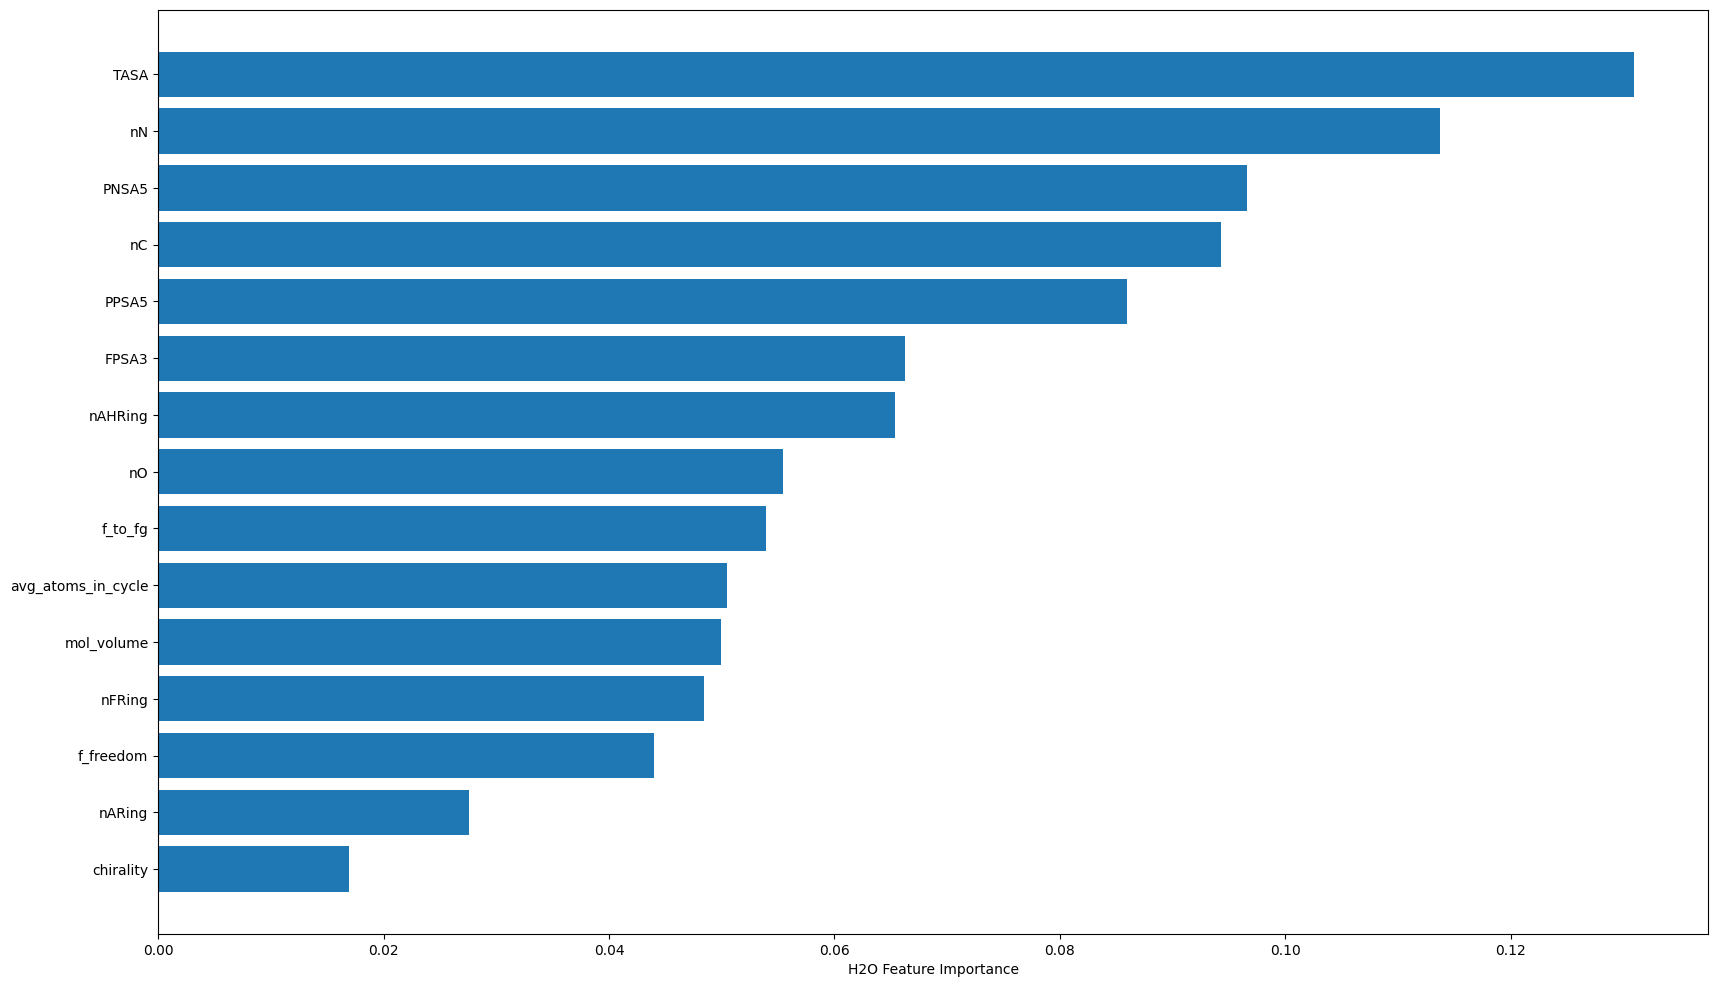

In [62]:
import matplotlib.pyplot as plt

# best_model = aml.get_best_model()
permutation_varimp = best_model.permutation_importance(train, use_pandas=True, n_repeats=500)

sum_rows = permutation_varimp.sum(axis=1)
sum_rows = sum_rows / sum(sum_rows)

sorted_idx = sum_rows.argsort()
plt.figure(figsize=(20,12))
plt.barh(sum_rows.keys()[sorted_idx][::-1][:30][::-1], sum_rows[sorted_idx][::-1][:30][::-1])
plt.xlabel("H2O Feature Importance")

SHAP

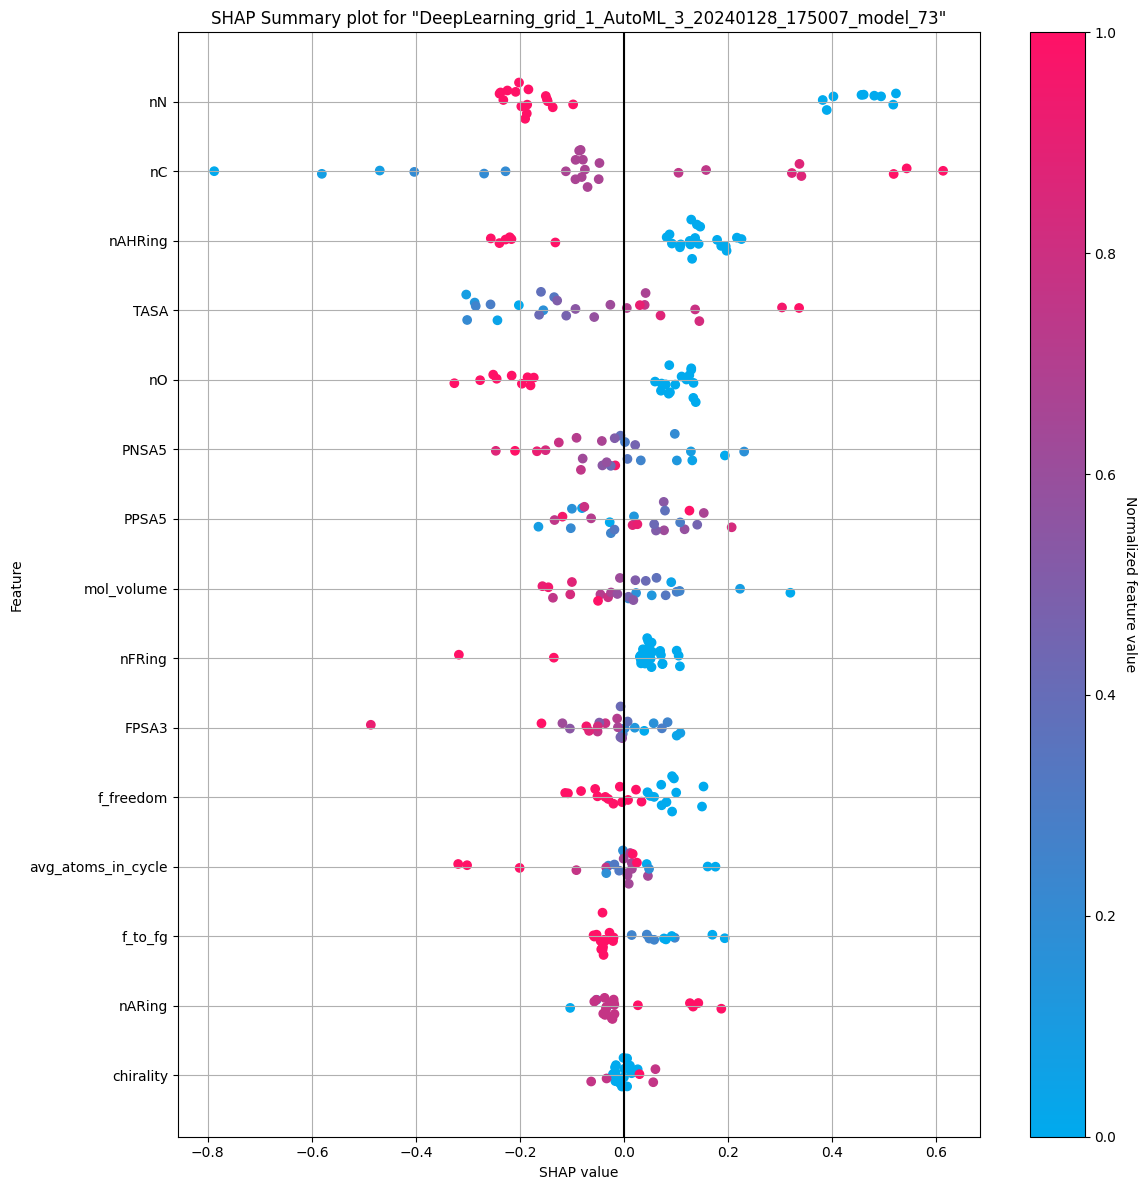

In [63]:
shap_plot = best_model.shap_summary_plot(test, background_frame=train, samples=2000)

VAR IMPORTANCE

deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%


c:\work\DrugDiscovery\drug-discovery-venv\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
c:\work\DrugDiscovery\drug-discovery-venv\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Text(0.5, 0, 'Percent')

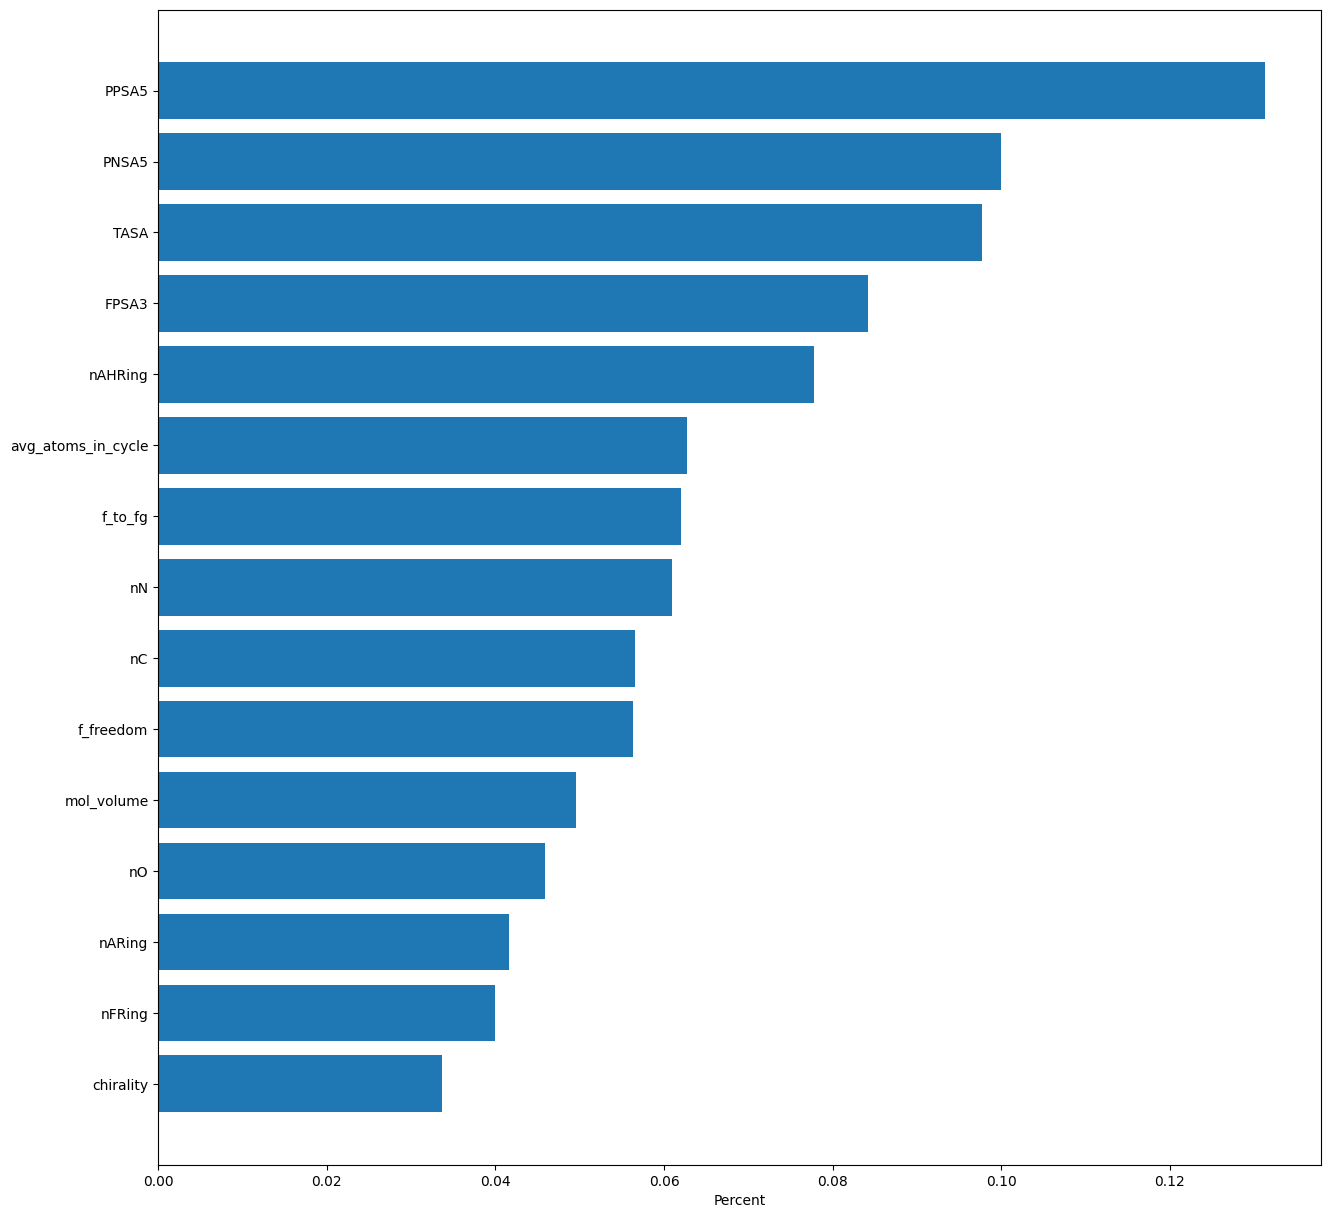

In [64]:
import matplotlib.pyplot as plt

# best_model = aml.get_best_model()

preds = best_model.predict(test)
true = test.as_data_frame()['logP']
predicted_values = preds.as_data_frame()['predict']

calculate_metrics(true, predicted_values)

importance = best_model.varimp(test)

fig, ax = plt.subplots(figsize=(15, 15))
ax.barh(importance['variable'][:][::-1], importance['percentage'][:][::-1])
ax.set_xlabel('Percent')


BEST MODEL SAVING

In [65]:
import os

MODEL_SAVE_PATH = r'C:\work\DrugDiscovery\main_git\XAI_Chem\ml_part\h2o_model\models\25.01.24_features\logP'

best_model = aml.get_best_model()

model_path = h2o.save_model(model=best_model, path=os.path.join(MODEL_SAVE_PATH, 'all_molecules_without_outliers_only_top_15_features'), force=True)
model_path

'C:\\work\\DrugDiscovery\\main_git\\XAI_Chem\\ml_part\\h2o_model\\models\\25.01.24_features\\logP\\all_molecules_without_outliers_only_top_15_features\\DeepLearning_grid_1_AutoML_3_20240128_175007_model_73'